In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training_set = pd.read_csv('Dataset/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


In [5]:
def data_prep(df, target):
    
    # Extract feature columns
    feature_columns = [col for col in df.columns if col != target]
    
    # Determine the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Convert features to float32
    X = df[feature_columns].values.astype(np.float32)
    
    # Convert target to float32
    y = df[target].values.astype(np.float32)
    
    # Handle target based on type
    if target_type in (np.int64, np.int32):
    # One hot encode for classification
        y = pd.get_dummies(df[target]).values.astype(np.float32)
    else:
    # For regression, just convert to float32
        y = df[target].values.astype(np.float32)
    return X, y

In [6]:
# X is pixels, y is labels

X_train, y_train = data_prep(training_set, 'label')
X_test, y_test = data_prep(test_set, 'label')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_test[0])

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


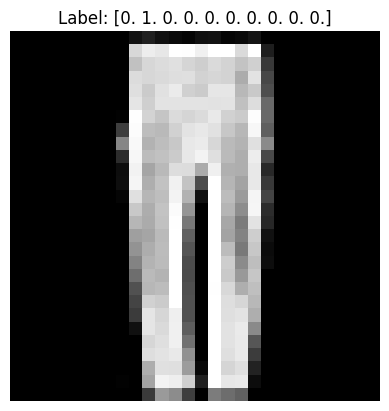

In [7]:
#visualising one image

# choosing an image
image_array = X_train[69]
label = y_train[69]

# reshape 784 to 28x28
image_array = image_array.reshape(28, 28)

# plotting the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [19]:
# rescaling the pixel values down to values between 0 - 1 for efficiency of neural network

X_train = X_train / 255.0
X_test = X_test / 255.0

In [20]:
class Tanh:
    def __init__(self):
        self.name = 'tanh'

    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, x):
        return 1 - np.tanh(x) ** 2

class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.name = 'leaky_relu'

    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, x):
        return np.where(x > 0, 1, self.alpha)
    
class Softmax:
    def __init__(self, crossEntropy=False):
        self.x_copy = None
        self.cross_entropy = crossEntropy
        self.output = None  # Store output for backward pass

    def softmax(self, x):
        stable_exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        y_prob = stable_exp_x / np.sum(stable_exp_x, axis=1, keepdims=True)
        return y_prob

    def forward(self, x):
        self.x_copy = x
        self.output = self.softmax(x)
        return self.output

    def backward(self, dout):
        batch_size = self.output.shape[0]
        if self.cross_entropy:
            # When used with cross-entropy loss, gradient simplifies
            return dout
        else:
            # For each sample in the batch
            jacobian = np.zeros_like(dout)
            for i in range(batch_size):
                S = self.output[i].reshape(-1, 1)
                J = np.diagflat(S) - np.dot(S, S.T)
                jacobian[i] = np.dot(J, dout[i])
            return jacobian
    
class Linear:
    def __init__(self, input_num, output_num):

        # For gradient descent
        self.db = None
        self.dw = None
        
        # Set random seed for reproducibility
        self.rng = np.random.default_rng(42)
        
        # Initialize weights using Xavier initialization
        xavier_scale = np.sqrt(2.0 / (input_num + output_num))
        self.weights = self.rng.normal(0, xavier_scale, size=(input_num, output_num))
        
        # Initialize biases to zeros
        self.bias = np.zeros((1, output_num))
        
        # Store input for backprop
        self.input = None
    
    def forward(self, x):
        # Forward pass remains the same
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad_output):
        # Calculate gradients
        self.dw = np.dot(self.input.T, grad_output)
        self.db = np.sum(grad_output, axis=0, keepdims=True)
        
        # Store gradients for optimizer
        self.weight_grad = self.dw
        self.bias_grad = self.db
        
        # Gradient for next layer
        dx = np.dot(grad_output, self.weights.T)
        return dx
    
    def update_params(self, learning_rate):
    
        if self.dw is not None and self.db is not None:
            self.weights -= learning_rate * self.dw
            self.bias -= learning_rate * self.db
        else:
            print("Error: gradients not computed yet")

class CrossEntropyLoss:

    def __init__(self, softmax=False):
        self.y_pred = None
        self.y_true = None
        self.softmax = softmax
        self.batch_size = None

    def forward(self, y_pred, y_true):
        self.batch_size = y_pred.shape[0]

        self.y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
        self.y_true = y_true

        loss = -np.sum(y_true * np.log(self.y_pred)) / self.batch_size
        return loss

    def backward(self):
        return (self.y_pred - self.y_true) / self.batch_size

class InvertedDropout:
    def __init__(self, rate):
        self.dropout_rate = rate
        self.mask = None
        self.rng = np.random.default_rng(42)

    def forward(self, x, training=True):
        if training:
            init_mask = self.rng.random(x.shape)
            self.mask = (init_mask > self.dropout_rate).astype(np.float32)
            return x * self.mask / (1 - self.dropout_rate)
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

In [ ]:
class BatchNorm:
    def __init__(self, num_features, epsilon=1e-5, momentum=0.9):
        self.num_features = num_features
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, num_features))
        self.beta = np.zeros((1, num_features))
        self.running_mean = np.zeros((1, num_features))
        self.running_var = np.ones((1, num_features))
        self.training = True
        # Store input for backward pass
        self.input = None

    def forward(self, x):
        # Store input for backward pass
        self.input = x
        
        if self.training:
            batch_mean = np.mean(x, axis=0, keepdims=True)
            batch_var = np.var(x, axis=0, keepdims=True)
            
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
            
            # Normalize
            x_norm = (x - batch_mean) / np.sqrt(batch_var + self.epsilon)
            
            # Store values for backward pass
            self.batch_mean = batch_mean
            self.batch_var = batch_var
            self.x_norm = x_norm
            
        else:
            # Use running statistics for inference
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
        
        # Scale and shift
        out = self.gamma * x_norm + self.beta
        return out

    def backward(self, dout):
        # Get batch size
        m = dout.shape[0]
        
        # Gradients for beta and gamma
        self.dbeta = np.sum(dout, axis=0, keepdims=True)
        self.dgamma = np.sum(dout * self.x_norm, axis=0, keepdims=True)
        
        # Gradient with respect to normalized input
        dx_norm = dout * self.gamma
        
        # Gradient with respect to variance
        dvar = np.sum(dx_norm * (self.input - self.batch_mean) * -0.5 * 
                     np.power(self.batch_var + self.epsilon, -1.5), axis=0, keepdims=True)
        
        # Gradient with respect to mean
        dmean = np.sum(dx_norm * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0, keepdims=True) + \
                dvar * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)
        
        # Gradient with respect to input
        dx = dx_norm / np.sqrt(self.batch_var + self.epsilon) + \
             dvar * 2 * (self.input - self.batch_mean) / m + \
             dmean / m
             
        return dx

    def update_params(self, learning_rate):
        self.gamma -= learning_rate * self.dgamma
        self.beta -= learning_rate * self.dbeta

In [21]:
class NeuralNetwork:
    def __init__(self, layers, loss_function):
        self.layers = layers
        self.loss_fn = loss_function
    
    def forward(self, x):
        activation = x
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update_params(self):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(self.learning_rate)

    def train_mode(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval_mode(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

    def train(self, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
        self.train_mode()
        self.learning_rate = learning_rate
        n_samples = len(X_train)
        losses = []
        
        # Create indices array for shuffling
        indices = np.arange(n_samples)
        
        for epoch in range(epochs):
            # Shuffle data at start of each epoch
            np.random.shuffle(indices)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            total_loss = 0
            n_batches = 0

            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                batch_X = X_shuffled[i:i + batch_size]
                batch_y = y_shuffled[i:i + batch_size]

                # Forward pass
                predictions = self.forward(batch_X)
                
                # Compute loss
                loss = self.loss_fn.forward(predictions, batch_y)
                total_loss += loss
                n_batches += 1
                
                # Backward pass
                grad = self.loss_fn.backward()
                self.backward(grad)
                
                # Update parameters
                self.update_params()
            
            # Calculate average loss per epoch
            avg_loss = total_loss / n_batches
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
        
        return losses
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X_test, y_test):
        self.eval_mode()
        predictions = self.predict(X_test)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

In [22]:
def plot_loss(loss_hist):
    plt.plot(loss_hist)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

In [29]:
model = NeuralNetwork(
    [
        Linear(X_train.shape[1], 300),
        BatchNorm(300),
        LeakyReLU(),
        InvertedDropout(0.2),
        Linear(300, 10),       
        BatchNorm(10),
        Softmax()
    ],
    CrossEntropyLoss()
)

# Train the model with the updated learning rate
loss_hist = model.train(X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001)
plot_loss(loss_hist)

Epoch 0/200, Loss: 1873546.2995


In [ ]:
# Evaluate model
accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

y_pred = model.predict(X_test[:100])
y = y_test[:300]
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test[:100], axis=1)
print("Predicted classes:", predicted_classes)
print("True classes:", true_classes)